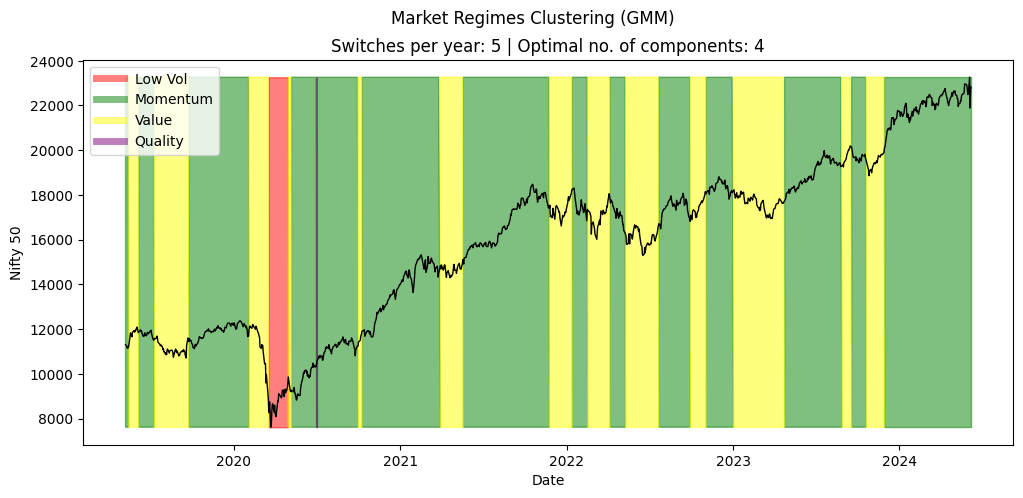

In [9]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
# from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load your data
df = pd.read_excel("./nifty50.xlsx")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
# df  = df[df.index<'20-01-01']

# Calculate the rolling percentage change
df['1M_return'] = df['Close'].pct_change(21).rolling(21).mean()
# df['2M_return'] = df['Close'].pct_change(42).rolling(21).mean()

# Drop NaN values
df = df.dropna()

# Extract the relevant features
features = df.filter(like='return').columns.tolist()
X = df[features].values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optimize the number of components on the training data
bic_scores = []
aic_scores = []
n_components_range = range(1, 10)  # Test for 1 to 10 components

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))
    aic_scores.append(gmm.aic(X_scaled))

# # Plot BIC and AIC scores to visualize the optimal number of components
# plt.figure(figsize=(12, 3))
# plt.plot(n_components_range, bic_scores, label='BIC', marker='o')
# plt.plot(n_components_range, aic_scores, label='AIC', marker='o')
# plt.xlabel('Number of Components')
# plt.ylabel('Score')
# plt.title('BIC and AIC Scores for Different Number of Components')
# plt.legend()
# plt.grid(True)
# plt.show()

# Select the optimal number of components based on the minimum BIC score
optimal_n_components = n_components_range[np.argmin(bic_scores)]
# print(f'Optimal number of components based on BIC: {optimal_n_components}')

# Training Model
gmm = GaussianMixture(n_components=optimal_n_components, random_state=42)
gmm.fit(X_scaled)

# Predict the market regimes
df['Regime'] = gmm.predict(X_scaled)
# df['Regime'] = df['Regime'].rolling(window=5).last().round()

# Calculate the total number of regime switches
regime_switches = (df['Regime'].diff() != 0).sum()

# Determine the total number of years in the dataset
total_years = (df.index[-1] - df.index[0]).days / 252

# Compute the average number of switches per year
avg_switches_per_year = regime_switches / total_years
# print(f'Average number of regime switches per year: {avg_switches_per_year:.2f}')

# Define regime labels and colors
regime_labels = {0: 'Momentum', 1: 'Value', 2: 'Quality', 3: 'Low Vol'}
regime_colors = {'Low Vol': 'red', 'Momentum': 'green', 'Value': "yellow", 'Quality': 'purple'}
df['Regime'] = df['Regime'].map(regime_labels)

# Plot the results with filled areas for each regime
plt.figure(figsize=(12, 5))

# Limit to the last 7 years of data for better visualization
df = df.tail(252 * 5)

# Plot the adjusted close prices
plt.plot(df.index, df['Close'], color='black', label='Close', linewidth=1)

# Fill areas for each regime
for regime, color in regime_colors.items():
    regime_periods = df['Regime'] == regime
    plt.fill_between(df.index, df['Close'].min(), df['Close'].max(), where=regime_periods, color=color, alpha=0.5, interpolate=True)

plt.suptitle('Market Regimes Clustering (GMM)')
plt.title(f'Switches per year: {avg_switches_per_year:.0f} | Optimal no. of components: {optimal_n_components}')
plt.xlabel('Date')
plt.ylabel('Nifty 50')
handles = [plt.Line2D([0], [0], color=color, lw=5, alpha=0.5) for color in regime_colors.values()]
labels = list(regime_colors.keys())
plt.legend(handles, labels, loc='best')
plt.show()

# Evaluate the GMM model
bic = gmm.bic(X_scaled)
aic = gmm.aic(X_scaled)
# print(f'BIC: {bic}')
# print(f'AIC: {aic}')
